In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K

In [2]:
#Download Data
import kagglehub
path = kagglehub.dataset_download("atikaakter11/brain-tumor-segmentation-dataset")
print("Path to dataset files:", path)
print(os.listdir(path))

100%|██████████| 106M/106M [00:00<00:00, 143MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/atikaakter11/brain-tumor-segmentation-dataset/versions/1
['Brain Tumor Segmentation Dataset']


In [12]:
data_path = os.path.join(path,'Brain Tumor Segmentation Dataset')
print(os.listdir(os.path.join(data_path, 'image')))
classes = ['1', '2', '3']
images = []
masks = []
labels = []
target_size = (128, 128)
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(class_name))
    mask_folder = os.path.join(data_path, 'mask', str(class_name))
    if os.path.exists(image_folder) and os.path.exists(mask_folder):
        for image_name in tqdm(os.listdir(image_folder), desc=class_name):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size)
                image = image / 255.0
                mask_name = image_name.replace('.jpg', '_m.jpg').replace('.png', '_m.png')
                mask_path = os.path.join(mask_folder, mask_name)
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, target_size)
                    mask = mask / 255.0
                    images.append(image)
                    masks.append(mask)
                    labels.append(class_name)
images = np.array(images).reshape(-1, 128, 128, 1)
masks = np.array(masks).reshape(-1, 128, 128, 1)
labels = np.array(labels)
print(f"Number of images : {len(images)}, Number of masks : {len(masks)}, Number of labels: {len(labels)}")

['1', '0', '2', '3']


1:   0%|          | 0/649 [00:00<?, ?it/s]

2:   0%|          | 0/999 [00:00<?, ?it/s]

3:   0%|          | 0/994 [00:00<?, ?it/s]

Number of images : 2642, Number of masks : 2642, Number of labels: 2642


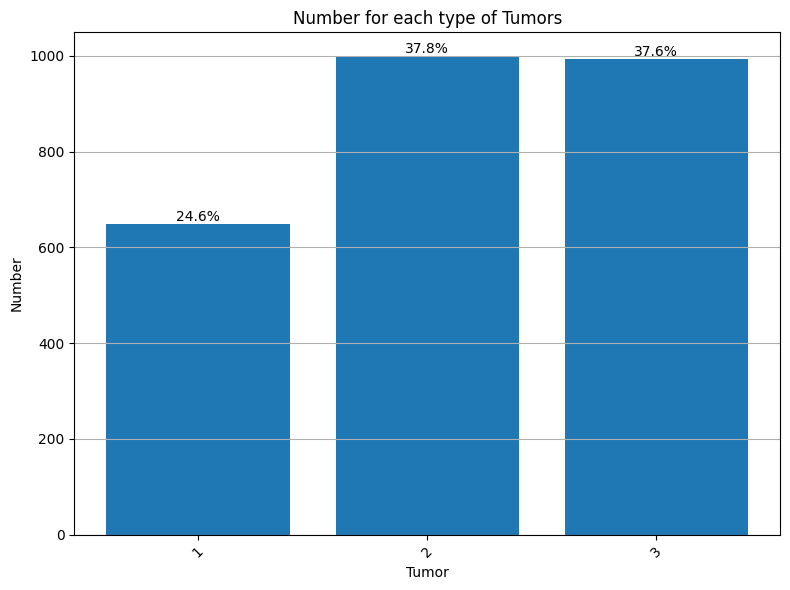

In [13]:
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values())
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')
plt.xlabel('Tumor')
plt.ylabel('Number')
plt.title('Number for each type of Tumors')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

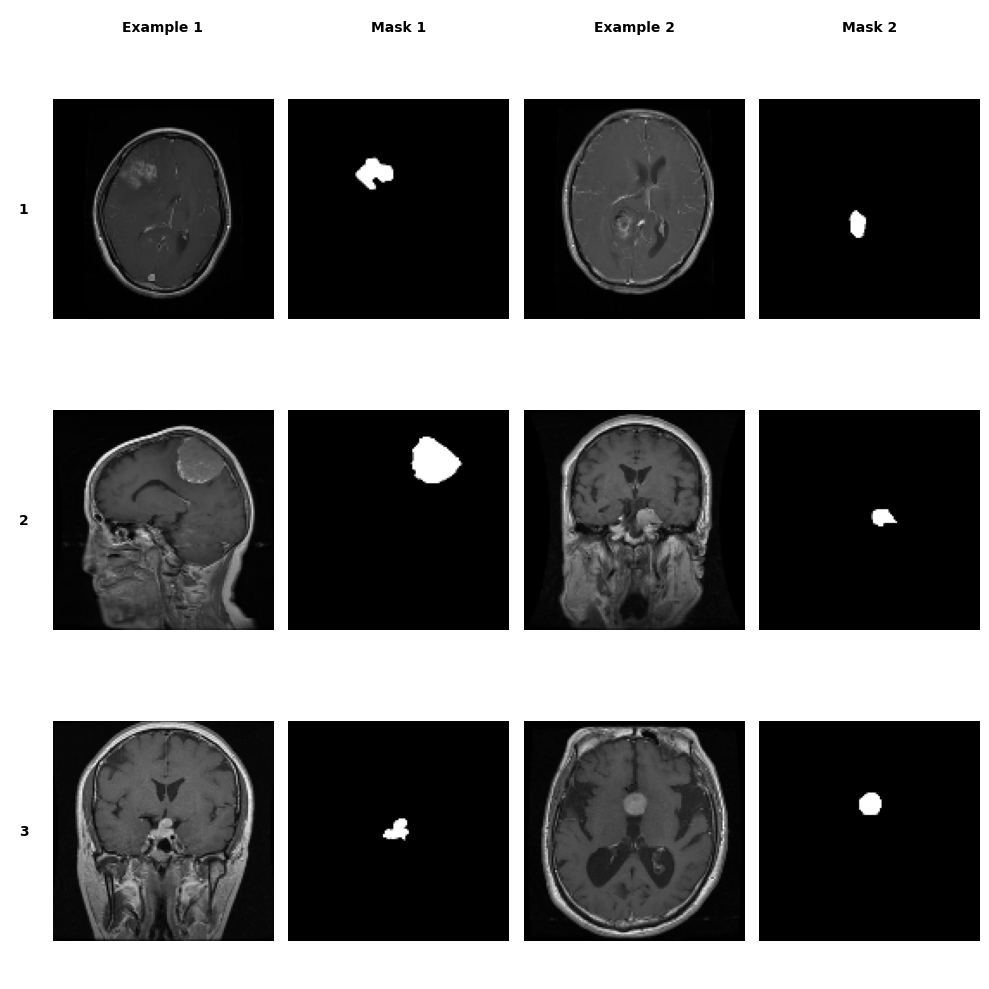

In [22]:
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(10, 10),gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4] * len(classes)})
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')
axs[0, 1].text(0.5, 0.5, "Example 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')
axs[0, 2].text(0.5, 0.5, "Mask 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')
axs[0, 3].text(0.5, 0.5, "Example 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')  # Enlever les axes
axs[0, 4].text(0.5, 0.5, "Mask 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')  # Enlever les axes

for i, class_name in enumerate(classes):
    class_index = class_name
    example_index1 = np.where(labels == class_index)[0][0]
    example_index2 = np.where(labels == class_index)[0][2]
    image1 = images[example_index1]
    mask1 = masks[example_index1]
    image2 = images[example_index2]
    mask2 = masks[example_index2]
    axs[i + 1, 1].imshow(image1, cmap='gray')
    axs[i + 1, 1].axis('off')
    axs[i + 1, 2].imshow(mask1, cmap='gray')
    axs[i + 1, 2].axis('off')
    axs[i + 1, 3].imshow(image2, cmap='gray')
    axs[i + 1, 3].axis('off')
    axs[i + 1, 4].imshow(mask2, cmap='gray')
    axs[i + 1, 4].axis('off')
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')
plt.tight_layout()
plt.show()

In [23]:
images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(images, masks, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True)

print(f"Images: {images_train.shape}, Masks: {masks_train.shape}, Labels: {labels_train.shape}")
print(f"Images: {images_val.shape}, Masks: {masks_val.shape}, Labels: {labels_val.shape}")

Images: (1849, 128, 128, 1), Masks: (1849, 128, 128, 1), Labels: (1849,)
Images: (793, 128, 128, 1), Masks: (793, 128, 128, 1), Labels: (793,)


In [24]:
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)

    while True:
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield img_batch, mask_batch

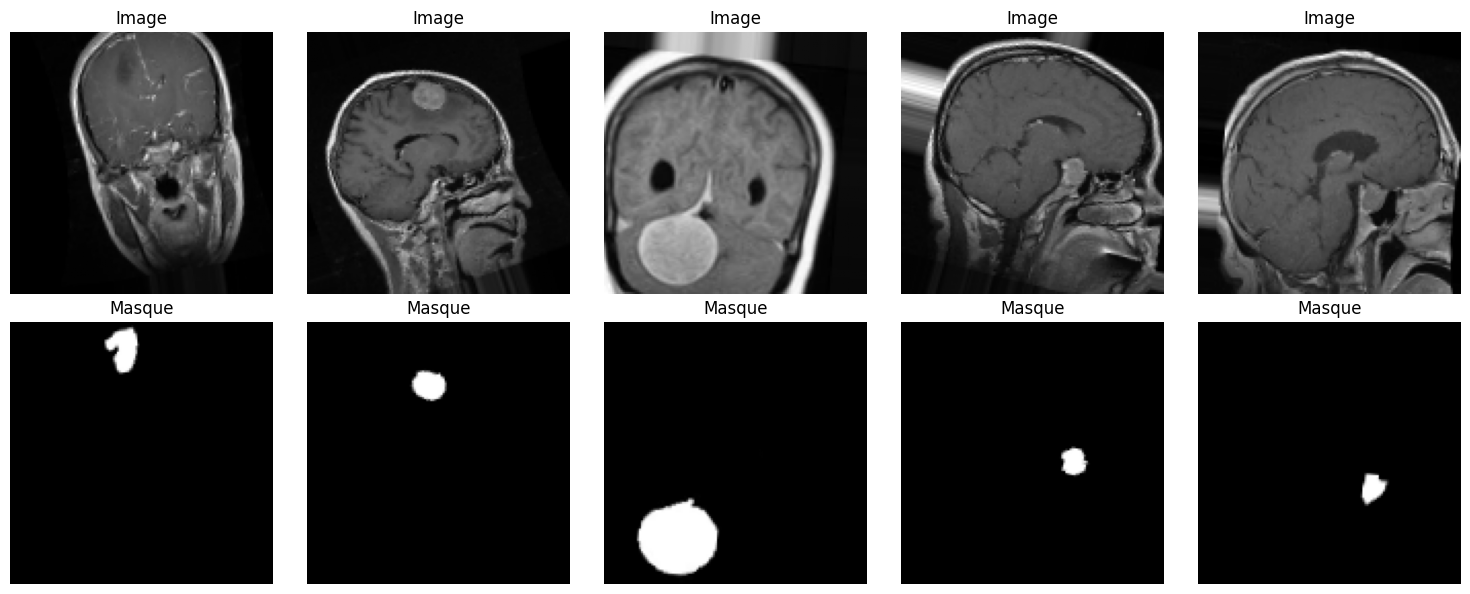

In [27]:
def plot_images(images, masks, num_images=3):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title('Image')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')
        plt.axis('off')
        plt.title('Masque')
    plt.tight_layout()
    plt.show()
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))
plot_images(images_batch, masks_batch, num_images=5)



In [28]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

In [32]:
def unet_model(input_shape):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (128, 128, 1)
model = unet_model(input_shape)
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy',dice_coefficient,iou])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 128, 128, 64)   │              0 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ dropout_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 64)     │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 64, 64, 128)    │              0 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 128)    │              0 │ conv2d_60[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 32, 32, 256)    │              0 │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 16, 16, 256)    │              0 │ conv2d_62[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 16, 16, 512)    │              0 │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 8, 8, 512)      │              0 │ conv2d_64[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model_checkpoint = ModelCheckpoint('best_unetmodel.keras', monitor='val_dice_coefficient', save_best_only=True, mode='max', verbose=1)

#early_stopping = EarlyStopping(monitor='val_dice_coefficient',patience=10, mode='max', verbose=1)

batch_size = 64
train_gen = train_generator(images_train, masks_train, batch_size=batch_size)
history = model.fit(
    train_gen,
    steps_per_epoch=len(images_train) // batch_size,
    epochs=200,
    validation_data=(images_val, masks_val),
    #callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.9869 - dice_coefficient: 0.8974 - iou: 0.8140 - loss: 0.0056 - val_accuracy: 0.9915 - val_dice_coefficient: 0.8778 - val_iou: 0.7833 - val_loss: 0.0098
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.9870 - dice_coefficient: 0.8982 - iou: 0.8152 - loss: 0.0055 - val_accuracy: 0.9914 - val_dice_coefficient: 0.8741 - val_iou: 0.7776 - val_loss: 0.0108
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.9867 - dice_coefficient: 0.8970 - iou: 0.8134 - loss: 0.0057 - val_accuracy: 0.9915 - val_dice_coefficient: 0.8752 - val_iou: 0.7793 - val_loss: 0.0100
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.9867 - dice_coefficient: 0.8957 - iou: 0.8112 - loss: 0.0059 - val_accuracy: 0.9914 - val_dice_coefficient: 0.8735 - val_iou: 0.7767 - val_loss: 0.0107
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.9872 - dice_coefficient: 0.8918 - iou: 0.8048 - loss: 0.0

In [43]:
train_loss, train_accuracy, train_dice_coef, train_iou_coef = model.evaluate(images_train, masks_train, verbose=1)
print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Dice Coefficient: {train_dice_coef:.4f}')
print(f'Training IoU Coefficient: {train_iou_coef:.4f}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9921 - dice_coefficient: 0.9266 - iou: 0.8633 - loss: 0.0037
Training Loss: 0.0035
Training Accuracy: 0.9924
Training Dice Coefficient: 0.9262
Training IoU Coefficient: 0.8626


In [44]:
val_loss, val_accuracy, val_dice_coef, val_iou_coef = model.evaluate(images_val, masks_val, verbose=1)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Dice Coefficient: {val_dice_coef:.4f}')
print(f'Validation IoU Coefficient: {val_iou_coef:.4f}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9913 - dice_coefficient: 0.8891 - iou: 0.8014 - loss: 0.0093
Validation Loss: 0.0091
Validation Accuracy: 0.9917
Validation Dice Coefficient: 0.8902
Validation IoU Coefficient: 0.8030


In [46]:
predictions = model.predict(images_val)
predictions = (predictions > 0.5).astype(np.uint8)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [56]:
model.save("best_unetmodel.keras")



In [57]:
from google.colab import files
files.download("best_unetmodel.keras")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

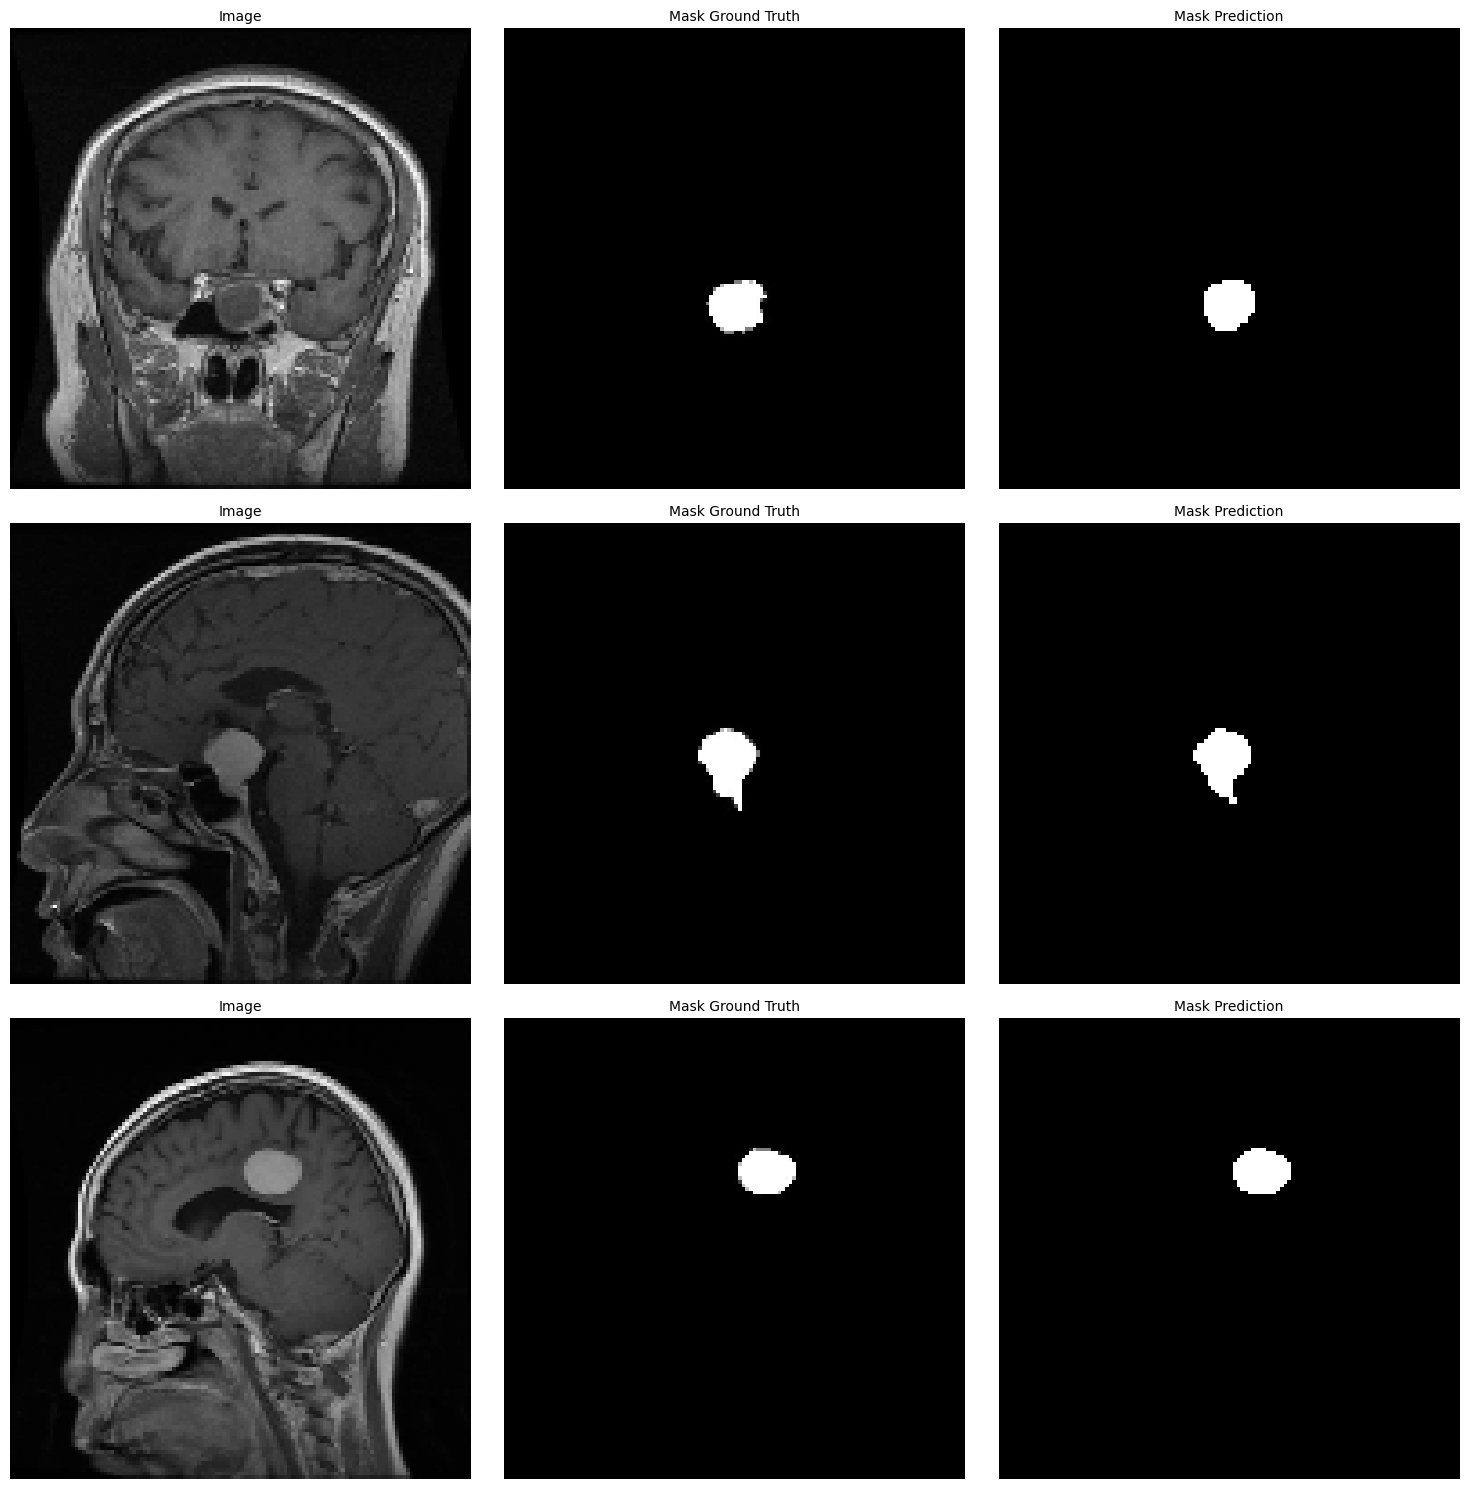

In [48]:
n = 3
plt.figure(figsize=(15, 15))

for i in range(n):
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(images_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Image',fontsize=10)
    plt.axis('off')
    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(masks_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Mask Ground Truth',fontsize=10)
    plt.axis('off')
    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(predictions[i+1].reshape(128, 128), cmap='gray')
    plt.title('Mask Prediction',fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [72]:
#Extract Information
from tensorflow.keras.models import load_model
model_path = "/mnt/data/best_unetmodel.keras"
model = load_model(model_path, custom_objects={"dice_coefficient": dice_coefficient, "iou": iou})

import cv2
import numpy as np

from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"✅ 文件已上传: {image_path}")

image_path = list(uploaded.keys())[0]
print(f"✅ Image Upload!: {image_path}")

import os
new_path = "image_fixed.jpg"
os.rename("Tr-pi_0015 (2).jpg", new_path)

image = cv2.imread(new_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (128, 128))
image_input = image_resized.astype(np.float32) / 255.0
image_input = np.expand_dims(image_input, axis=[0, -1])
pred_mask = model.predict(image_input)
threshold = 0.5
pred_mask_binary = (pred_mask[0, :, :, 0] > threshold).astype(np.uint8)

from skimage.measure import regionprops
tumor_pixels = np.sum(pred_mask_binary > 0)
pixel_spacing = 0.2
tumor_size_cm = (tumor_pixels * pixel_spacing**2) / 100
properties = regionprops(pred_mask_binary)
if properties:
    centroid = properties[0].centroid
else:
    centroid = (0, 0)

h, w = pred_mask_binary.shape
center_x, center_y = w / 2, h / 2
tumor_x, tumor_y = centroid

if tumor_x < center_x and tumor_y < center_y:
    location = "Left Parietal Region"
elif tumor_x > center_x and tumor_y < center_y:
    location = "Right Parietal Region"
elif tumor_x < center_x and tumor_y > center_y:
    location = "Left Temporal Region"
else:
    location = "Right Temporal Region"
brain_midline = w // 2
midline_shift = abs(tumor_x - brain_midline)
mass_effect = "No significant mass effect" if midline_shift < 10 else "Midline shift detected"
from skimage.measure import regionprops
tumor_pixels = np.sum(pred_mask_binary > 0)
pixel_spacing = 0.2
tumor_size_cm = (tumor_pixels * pixel_spacing**2) / 100
properties = regionprops(pred_mask_binary)
if properties:
    centroid = properties[0].centroid
else:
    centroid = (0, 0)

h, w = pred_mask_binary.shape
center_x, center_y = w / 2, h / 2
tumor_x, tumor_y = centroid
if tumor_x < center_x and tumor_y < center_y:
    location = "Left Parietal Region"
elif tumor_x > center_x and tumor_y < center_y:
    location = "Right Parietal Region"
elif tumor_x < center_x and tumor_y > center_y:
    location = "Left Temporal Region"
else:
    location = "Right Temporal Region"

brain_midline = w // 2
midline_shift = abs(tumor_x - brain_midline)
mass_effect = "No significant mass effect" if midline_shift < 10 else "Midline shift detected"

tumor_info_str = f"""
    🔍 Tumor Prediction:
    - **Tumor Classification**: Meningioma
    - **Location**: {location}
    - **Size**: {round(tumor_size_cm, 2)} cm²
    - **Type**: Isointense on T1-weighted imaging, hyperintense on T2-weighted imaging
    - **Distribution Pattern**: Extra-axial lesion with clear boundaries, localized growth pattern
    - **Mass Effect**: {mass_effect}
    """
print("\n🔍 Tumor Information：")
print(tumor_info_str)

Saving Tr-pi_0015.jpg to Tr-pi_0015 (2).jpg
✅ 文件已上传: Tr-pi_0015 (2).jpg
✅ Image Upload!: Tr-pi_0015 (2).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step

🔍 Tumor Information：

    🔍 Tumor Prediction:
    - **Tumor Classification**: Meningioma
    - **Location**: Right Parietal Region
    - **Size**: 0.19 cm²
    - **Type**: Isointense on T1-weighted imaging, hyperintense on T2-weighted imaging
    - **Distribution Pattern**: Extra-axial lesion with clear boundaries, localized growth pattern
    - **Mass Effect**: Midline shift detected
    
